Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 14, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 10, 14, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 10, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 14, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 7, 32)         0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 5, 7, 32)         1

Epoch 1/200


2023-04-28 14:22:58.285365: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


40/40 [==============================] - 1s 20ms/step - loss: 2.0307 - accuracy: 0.2395 - val_loss: 1.8913 - val_accuracy: 0.1813 - lr: 0.0010
Epoch 2/200
40/40 [==============================] - 1s 17ms/step - loss: 1.8367 - accuracy: 0.3086 - val_loss: 1.9247 - val_accuracy: 0.1937 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - 1s 18ms/step - loss: 1.7431 - accuracy: 0.3680 - val_loss: 1.9080 - val_accuracy: 0.1922 - lr: 0.0010
Epoch 4/200
40/40 [==============================] - 1s 19ms/step - loss: 1.6217 - accuracy: 0.4242 - val_loss: 1.9073 - val_accuracy: 0.2156 - lr: 0.0010
Epoch 5/200
40/40 [==============================] - 1s 19ms/step - loss: 1.5363 - accuracy: 0.4836 - val_loss: 1.9345 - val_accuracy: 0.2172 - lr: 0.0010
Epoch 6/200
40/40 [==============================] - 1s 19ms/step - loss: 1.4301 - accuracy: 0.5293 - val_loss: 1.8833 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 7/200
40/40 [==============================] - 1s 20ms/step - loss: 1.3181 -

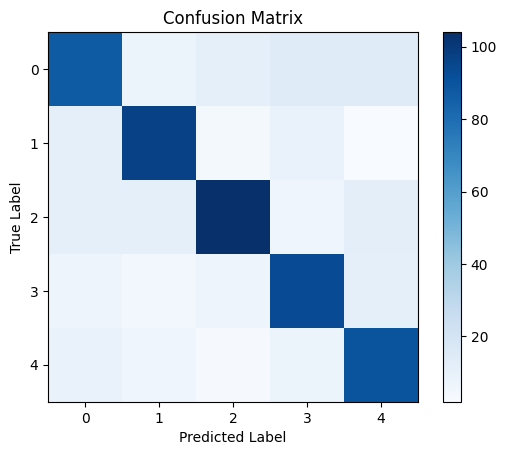

20/20 [==============================] - 0s 4ms/step


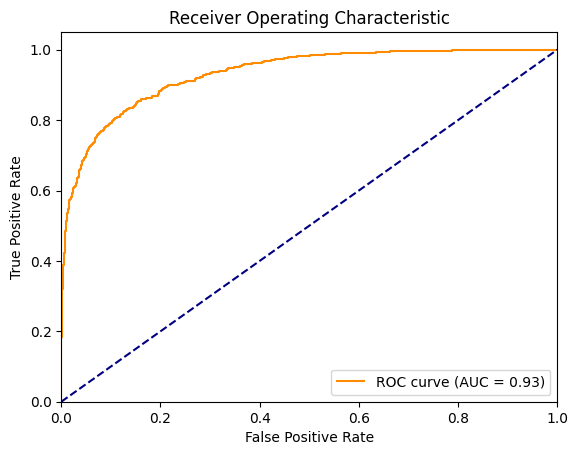

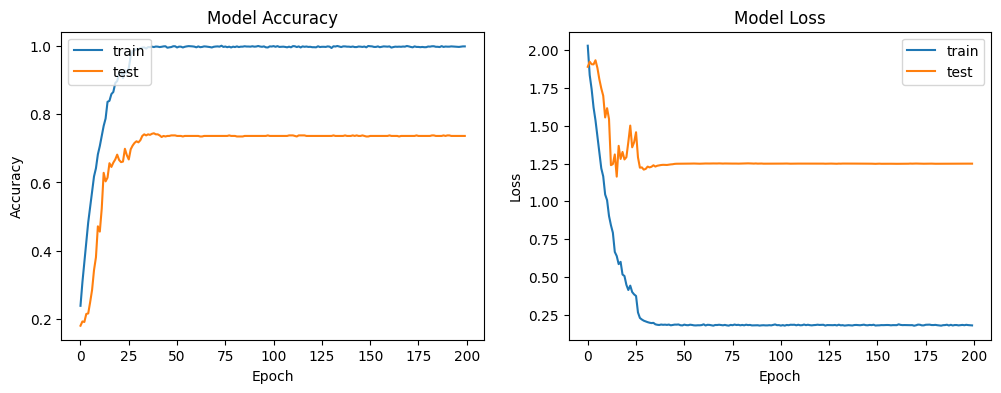

100/100 [==============================] - 0s 4ms/step
dumped as shape_EEG_feature.pkl (3200, 2381) (3200, 2246) 175.06057119369507


In [1]:
import os
import numpy as np
import time
import pickle
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2000
LEARNING_RATE = 0.001
L2_REGULARIZATION = 0.0005
DROPOUT_RATE = 0.5
img_size = 40 * 56
noise_size = 140

# Function to encode output labels from number indexes
def one_hot(y_):
    y_ = y_.reshape(len(y_))
    y_ = [int(x) for x in y_]
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

# Load and preprocess data
data = np.load(open('all_01.dat', 'rb'), allow_pickle=True)

EEG = preprocessing.minmax_scale(data[:, :140], axis=1)
EEG = EEG * 2 - 1
ima = preprocessing.minmax_scale(data[:, 140:], axis=1)
data = np.hstack((EEG, ima))

l0 = np.zeros([int(3200/5), 1])
for lab in range(1, 5):
    l_ = np.ones([int(3200/5), 1]) * lab
    l0 = np.vstack((l0, l_))

data = np.hstack((data, l0))
np.random.shuffle(data)

n_class = 5
label = data[:, (img_size+noise_size):(img_size+noise_size)+1]
label = one_hot(label)
feature = data[:, :140]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, random_state=42)

t1 = time.time()

# Create the CNN model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((10, 14, 1), input_shape=(140,)),
        tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
        tf.keras.layers.Dense(n_class, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))
    ])
    return model

model = create_model()
model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Define the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

# Train the model with the learning rate scheduler callback
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute precision, recall, and F1-score for each class
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Save the classification report to a file
with open('classification_report.txt', 'w') as f:
    f.write(report)

print('Saved classification report to classification_report.txt')

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(n_class)
plt.xticks(tick_marks, range(n_class))
plt.yticks(tick_marks, range(n_class))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate predictions for the test set
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Convert the true labels to binary format
n_samples = y_true_classes.shape[0]
n_classes = np.unique(y_true_classes).shape[0]
y_true = np.zeros((n_samples, n_classes))
y_true[np.arange(n_samples), y_true_classes] = 1

# Compute the micro-averaged ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

EEG_features = model.predict(data[:, :140])
all_data = np.hstack((EEG_features, data[:, 140:]))

# Save the extracted features
pickle.dump(all_data, open('shape_EEG_feature.pkl', 'wb'))
print('dumped as shape_EEG_feature.pkl', data.shape, all_data.shape, time.time() - t1)

# Save the model's architecture as a JSON file
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model's weights as an HDF5 file
model.save_weights('model_weights.h5')

